# Case Study 7 - Produce farm zone map
## Description 
As a grower, I want to analyse my yield maps and farm data, so I can zone up my farm based on site variability. 
## Case Breakdown 
- **Actors:** Grower
- **Goals:** Customized needs for Grower
- **Scope** Local,Paddock-Scale
## Generalised case
I want to analyse a suite of spatial variables across a site so I can derive a classification of areas by similarity.
## Comparable cases
- I want to combine a suite of environmental variables, including weather (temperature, rainfall, humidity - all xyt), lunar phase (t) and greenness (xyt - see https://portal.tern.org.au/metadata/TERN/8542d90e-6e20-4ad8-b30d-0a171b61d3f5) and soils (pH, N, K, structure) for N (e.g. 50) candidate sites and then select derive a classification for each subunit based on a clustering algorithm.
## Stakeholders 
- **Name:** Tom Bishop
- **Contact:** thomas.bishop@sydney.edu.au


## Data Sources
Use Llara-Campey data including yield values and soil maps to develop classification of farm area into contiguous zones of relatively self-similar productivity. Variables should include the minimum zone area and the maximum number of zone classes to return.

This notebook can be delivered as a tool into which the user can load their own data in the form of spreadsheets containing points and associated values for the variables to take into account in the analysis. The requirement is either for comprehensive (raster) coverage for the area or of a set of point-based measurements for each variable (in which case a simple kriging or mesh interpolation will be applied).

### Generating STAC records from config files

In [1]:
from concurrent.futures import ProcessPoolExecutor
from stac_generator.factory import StacGeneratorFactory
from stac_generator.core import StacCollectionConfig , StacSerialiser
from pathlib import Path 

parent_path = Path().cwd()
# Scenario 1
configs = [
    parent_path / "llara_point_config.json",
    parent_path / "llara_raster_config.json",
    parent_path / "llara_shape_config.json",
    parent_path / "scenario_1_config.json"
]
output_path = parent_path / "generated"
collection_config = StacCollectionConfig(id="Collection")

# Serialising STAC records
with ProcessPoolExecutor(max_workers=8) as pool:
    generator = StacGeneratorFactory.get_collection_generator(source_configs=configs, collection_config=collection_config, pool=pool)
    serialiser = StacSerialiser(generator, output_path.as_posix())
    serialiser() 

2025-04-29T09:20:34-stac_generator.core.point.generator - INFO - Reading point asset: soil_measurement
2025-04-29T09:20:34-stac_generator.core.raster.generator - INFO - Reading raster asset: LlaraECa
2025-04-29T09:20:34-stac_generator.core.raster.generator - INFO - Reading raster asset: LlaraGammaK
2025-04-29T09:20:34-stac_generator.core.raster.generator - INFO - Reading raster asset: CampeyGammaK
2025-04-29T09:20:34-stac_generator.core.raster.generator - INFO - Reading raster asset: CampeyECa
2025-04-29T09:20:34-stac_generator.core.vector.generator - INFO - Reading vector asset: L1Boundary
2025-04-29T09:20:34-stac_generator.core.vector.generator - INFO - Reading vector asset: L3Boundary
2025-04-29T09:20:34-stac_generator.core.vector.generator - INFO - Reading vector asset: L4Boundary
2025-04-29T09:20:34-stac_generator.core.point.generator - INFO - Reading point asset: L1_2017_wheat
2025-04-29T09:20:34-stac_generator.core.point.generator - INFO - Reading point asset: L3_2017_wheat
2025

## Data Transformation
1. Select a grid scale appropriate for the anaysis (e.g. 100*100).
2. Import all values in as layers for each variable.
3. Interpolate to populate any empty cells.

In [2]:
# Loading in data cube 
from mccn.client import MCCN 

client = MCCN(endpoint = output_path/"collection.json", shape=(100, 100))
raw_ds = client.load()

In [3]:
raw_ds

<xarray.Dataset> Size: 4MB
Dimensions:      (time: 3, y: 100, x: 100)
Coordinates:
  * y            (y) float64 800B -30.25 -30.25 -30.26 ... -30.29 -30.29 -30.29
  * x            (x) float64 800B 149.8 149.8 149.8 149.8 ... 149.9 149.9 149.9
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 24B 2016-01-01T10:00:00 ... 2025-01-01
Data variables: (12/18)
    eca          (time, y, x) float64 240kB 0.0 0.0 0.0 ... -3.4e+38 -3.4e+38
    gammak       (time, y, x) float64 240kB 0.0 0.0 0.0 ... -3.4e+38 -3.4e+38
    L1Boundary   (time, y, x) int8 30kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    L3Boundary   (time, y, x) int8 30kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    L4Boundary   (time, y, x) int8 30kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    ECa          (time, y, x) float64 240kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...           ...
    DEM          (time, y, x) float64 240kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Sand         (time, y, x) float64 240kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    NDVI10       (time, y, x) float64 240kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    EC           (time, y, x) float64 240kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    yield_t_ha   (time, y, x) float64 240kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    moisture     (time, y, x) float64 240kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    L1Boundary:  {0: 'nodata', 1: 'L1Boundary'}
    L3Boundary:  {0: 'nodata', 1: 'L3Boundary'}
    L4Boundary:  {0: 'nodata', 1: 'L4Boundary'}

## Processing Raster data

We notice that raster layers have -3.4e-38 nodata values. For simplicity, we constrain the valid values to be in [-1e3, 1e3]

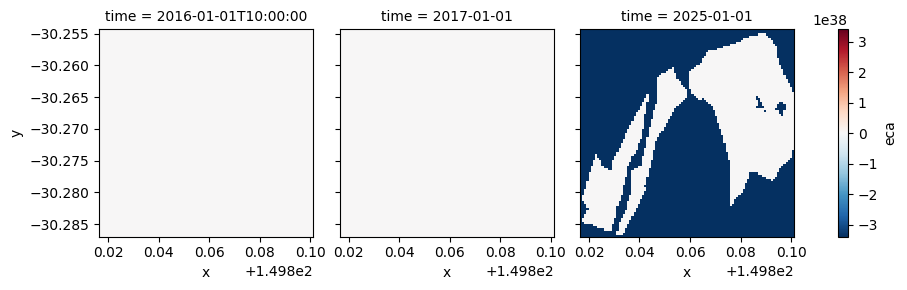

In [4]:
raw_ds["eca"].plot(x="x", y="y", col="time", col_wrap=3)

In [5]:
proc_ds = raw_ds.where((-1e3 <= raw_ds) & (raw_ds <= 1e3), 0)
proc_ds

<xarray.Dataset> Size: 4MB
Dimensions:      (time: 3, y: 100, x: 100)
Coordinates:
  * y            (y) float64 800B -30.25 -30.25 -30.26 ... -30.29 -30.29 -30.29
  * x            (x) float64 800B 149.8 149.8 149.8 149.8 ... 149.9 149.9 149.9
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 24B 2016-01-01T10:00:00 ... 2025-01-01
Data variables: (12/18)
    eca          (time, y, x) float64 240kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    gammak       (time, y, x) float64 240kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    L1Boundary   (time, y, x) int8 30kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    L3Boundary   (time, y, x) int8 30kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    L4Boundary   (time, y, x) int8 30kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    ECa          (time, y, x) float64 240kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...           ...
    DEM          (time, y, x) float64 240kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Sand         (time, y, x) float64 240kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    NDVI10       (time, y, x) float64 240kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    EC           (time, y, x) float64 240kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    yield_t_ha   (time, y, x) float64 240kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    moisture     (time, y, x) float64 240kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    L1Boundary:  {0: 'nodata', 1: 'L1Boundary'}
    L3Boundary:  {0: 'nodata', 1: 'L3Boundary'}
    L4Boundary:  {0: 'nodata', 1: 'L4Boundary'}

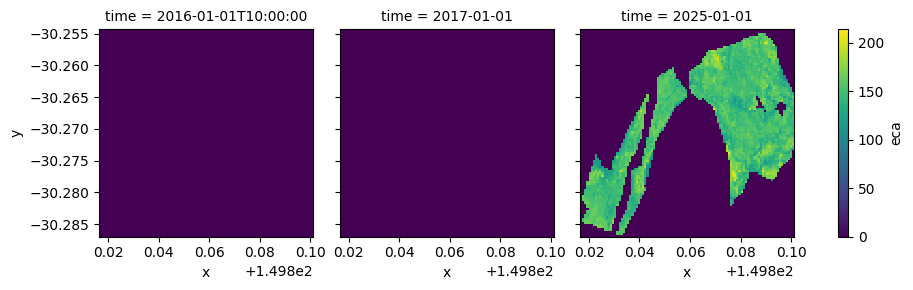

In [6]:
proc_ds["eca"].plot(x="x", y="y", col="time", col_wrap=3)

## Data Analysis/Visulisation
Apply a clustering algorithm to segment the space into the required number of zone classes.

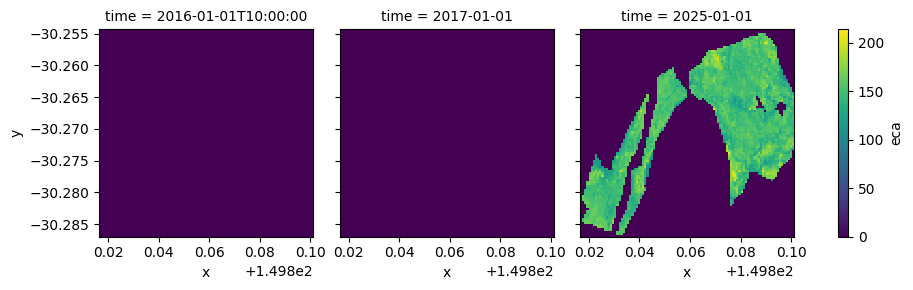

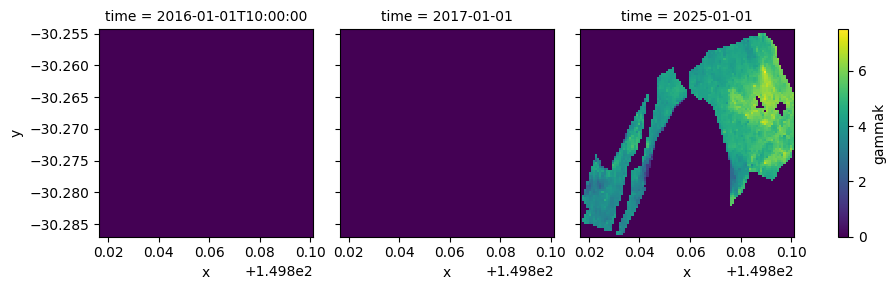

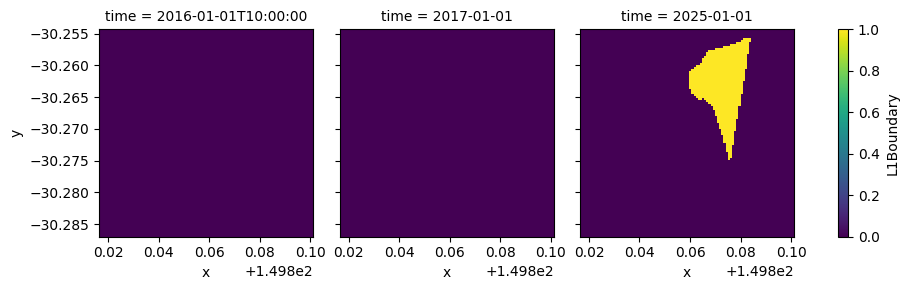

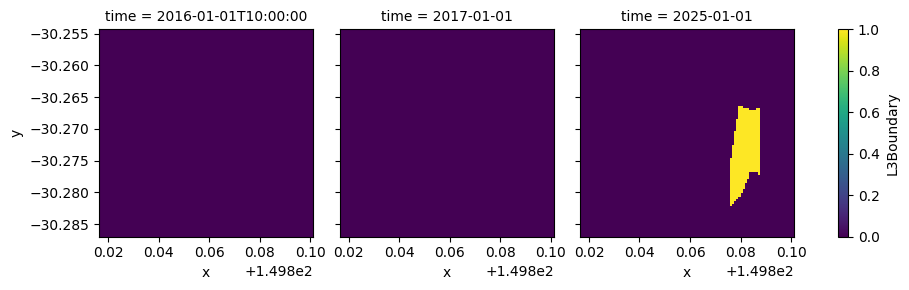

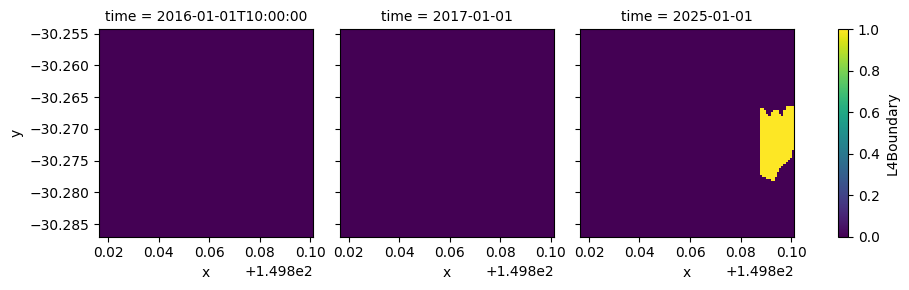

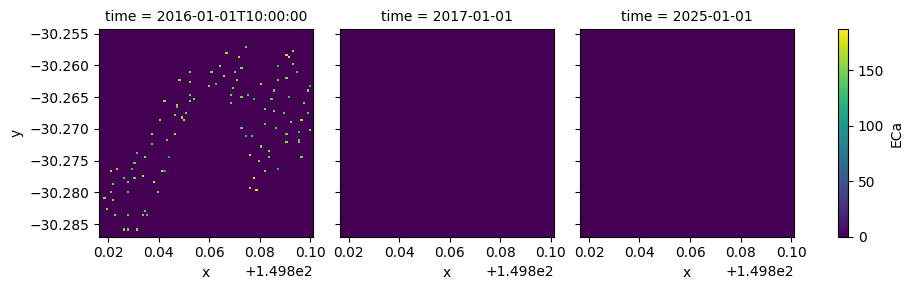

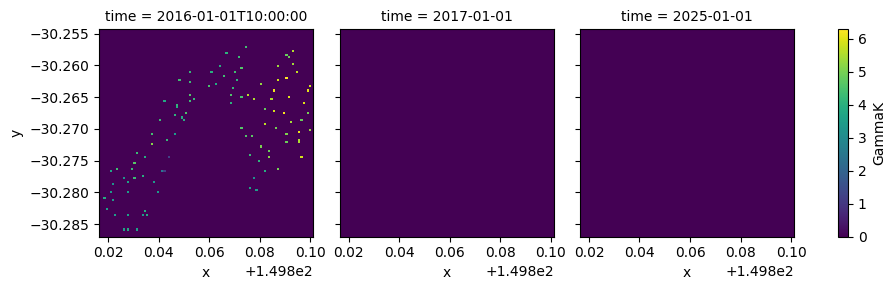

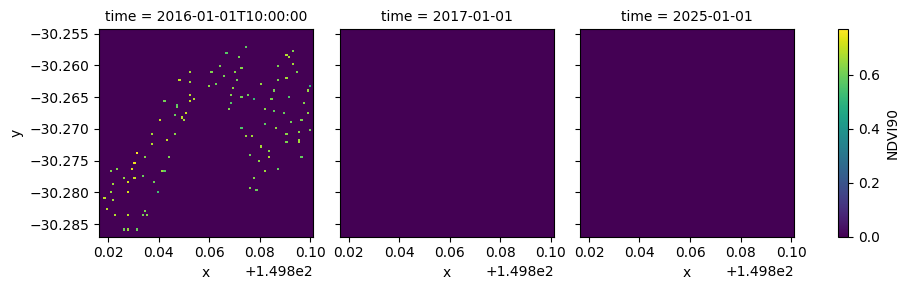

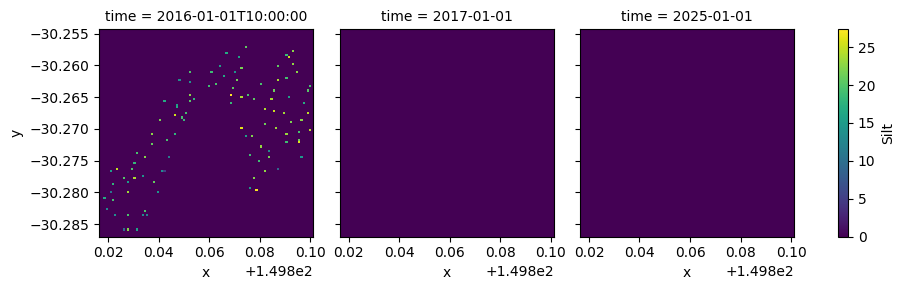

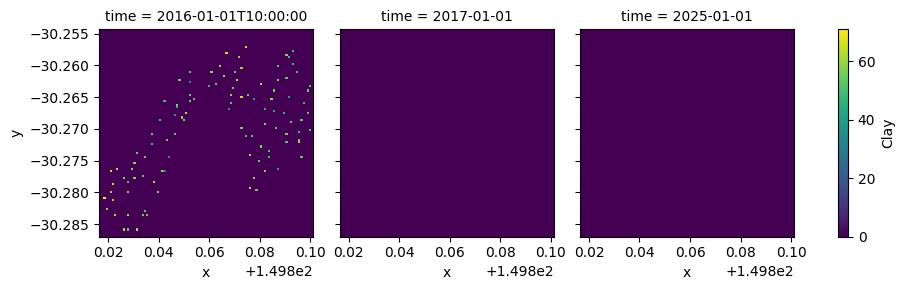

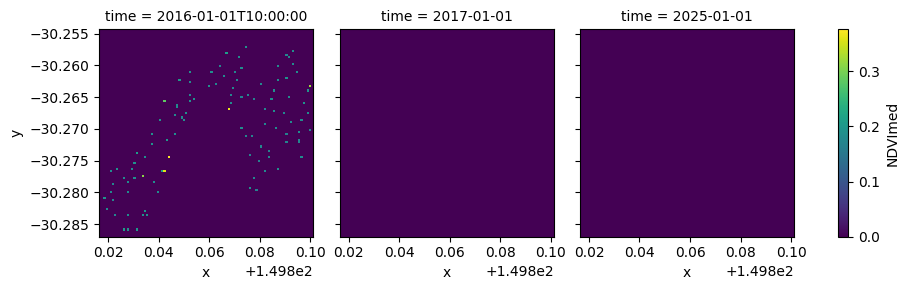

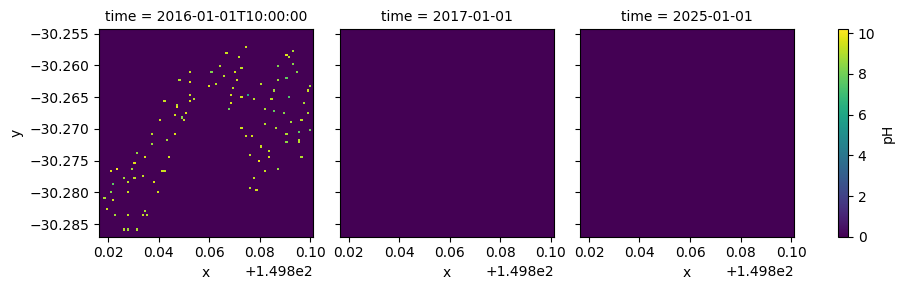

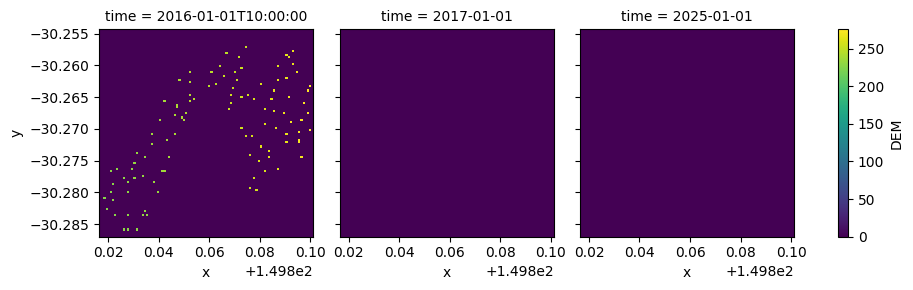

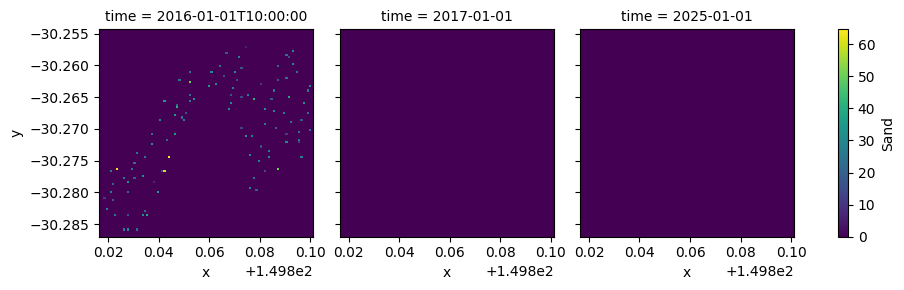

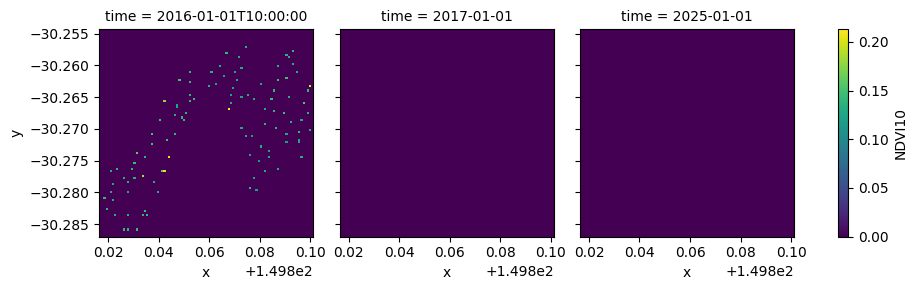

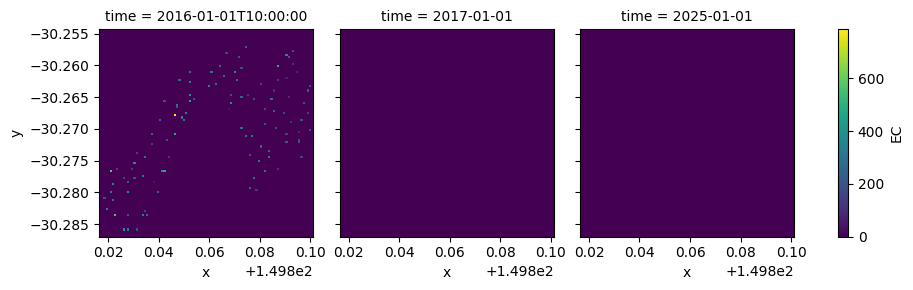

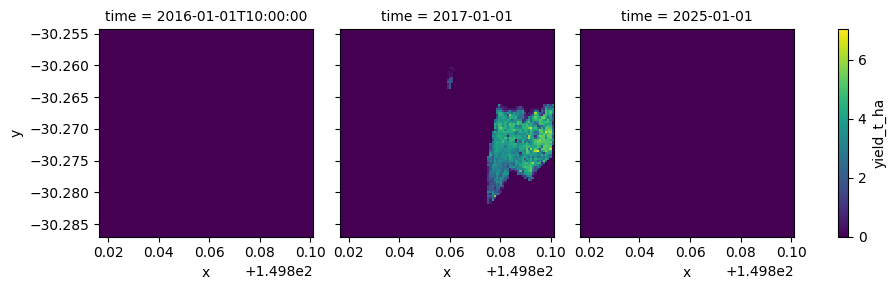

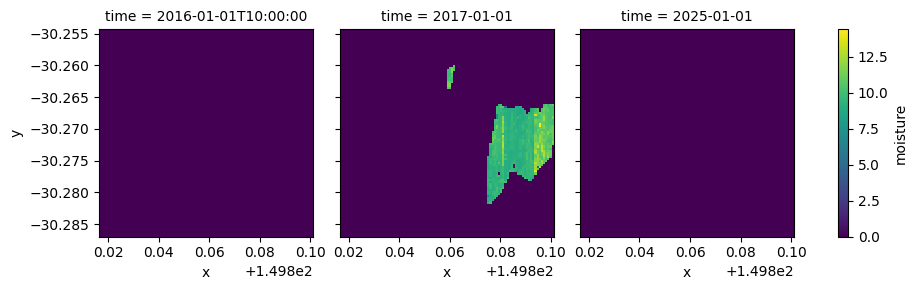

In [8]:
## Visualising other variables 
for var in proc_ds.data_vars.keys():
    proc_ds[var].plot(x="x", y="y", col="time", col_wrap=3)